In [1]:
# ============================================================
# SETUP: Import Libraries
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)
torch.manual_seed(42)

print("✅ Libraries loaded")

✅ Libraries loaded


In [2]:
# ============================================================
# LOAD DATA
# ============================================================

X_train = pd.read_csv('../../data/processed/X_train.csv')
X_test = pd.read_csv('../../data/processed/X_test.csv')

y_train_motor = pd.read_csv('../../data/processed/y_train_motor.csv').values.ravel()
y_test_motor = pd.read_csv('../../data/processed/y_test_motor.csv').values.ravel()

y_train_total = pd.read_csv('../../data/processed/y_train_total.csv').values.ravel()
y_test_total = pd.read_csv('../../data/processed/y_test_total.csv').values.ravel()

print(f"✅ Data loaded: {X_train.shape[0]} train, {X_test.shape[0]} test, {X_train.shape[1]} features")

✅ Data loaded: 4700 train, 1175 test, 22 features


### Evaluation Metrics Formulas

**R² (Coefficient of Determination):**
$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}} = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$$

Where:
- $SS_{res}$ = Residual sum of squares (prediction errors)
- $SS_{tot}$ = Total sum of squares (variance in actual values)
- $y_i$ = Actual value, $\hat{y}_i$ = Predicted value, $\bar{y}$ = Mean of actual values
- **Range:** (-∞, 1], where 1 = perfect prediction, 0 = predicting mean, <0 = worse than mean

**RMSE (Root Mean Squared Error):**
$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

- Measures average magnitude of errors in same units as target
- Penalizes large errors more than MAE (due to squaring)
- **Lower is better** (0 = perfect)

**MAE (Mean Absolute Error):**
$$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

- Average absolute difference between predictions and actual values
- More interpretable than RMSE (no squaring)
- **Lower is better** (0 = perfect)

In [ ]:
# Feature correlation heatmap
plt.figure(figsize=(14, 10))
corr_matrix = X_train.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot=False, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../../submission/feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Feature correlation matrix shows relationships between {X_train.shape[1]} voice features")

In [ ]:
# Visualize target distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# motor_UPDRS distribution
axes[0].hist(y_train_motor, bins=30, alpha=0.6, color='steelblue', edgecolor='black', label='Train')
axes[0].hist(y_test_motor, bins=30, alpha=0.6, color='coral', edgecolor='black', label='Test')
axes[0].set_xlabel('motor_UPDRS Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of motor_UPDRS Scores', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# total_UPDRS distribution
axes[1].hist(y_train_total, bins=30, alpha=0.6, color='steelblue', edgecolor='black', label='Train')
axes[1].hist(y_test_total, bins=30, alpha=0.6, color='coral', edgecolor='black', label='Test')
axes[1].set_xlabel('total_UPDRS Score', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of total_UPDRS Scores', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../../submission/target_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"motor_UPDRS - Train: [{y_train_motor.min():.1f}, {y_train_motor.max():.1f}], Test: [{y_test_motor.min():.1f}, {y_test_motor.max():.1f}]")
print(f"total_UPDRS - Train: [{y_train_total.min():.1f}, {y_train_total.max():.1f}], Test: [{y_test_total.min():.1f}, {y_test_total.max():.1f}]")

---
## 📊 Data Overview & Visualization

---
## 🤖 MODEL 1: Linear Regression

In [3]:
# Train on BOTH targets
lr_motor = LinearRegression().fit(X_train, y_train_motor)
lr_total = LinearRegression().fit(X_train, y_train_total)

# Predictions
pred_motor = lr_motor.predict(X_test)
pred_total = lr_total.predict(X_test)

# Metrics
results_lr = {
    'motor_R2': r2_score(y_test_motor, pred_motor),
    'motor_RMSE': np.sqrt(mean_squared_error(y_test_motor, pred_motor)),
    'motor_MAE': mean_absolute_error(y_test_motor, pred_motor),
    'total_R2': r2_score(y_test_total, pred_total),
    'total_RMSE': np.sqrt(mean_squared_error(y_test_total, pred_total)),
    'total_MAE': mean_absolute_error(y_test_total, pred_total)
}

print("📊 Linear Regression Results:")
print(f"  motor_UPDRS: R²={results_lr['motor_R2']:.3f}, RMSE={results_lr['motor_RMSE']:.2f}, MAE={results_lr['motor_MAE']:.2f}")
print(f"  total_UPDRS: R²={results_lr['total_R2']:.3f}, RMSE={results_lr['total_RMSE']:.2f}, MAE={results_lr['total_MAE']:.2f}")

📊 Linear Regression Results:
  motor_UPDRS: R²=0.122, RMSE=7.49, MAE=6.36
  total_UPDRS: R²=0.155, RMSE=9.68, MAE=8.06


---
## 🤖 MODEL 2: Polynomial Regression

In [4]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train on BOTH targets with STRONG Ridge regularization (alpha=100 for 275 features)
from sklearn.linear_model import Ridge
poly_motor = Ridge(alpha=100).fit(X_train_poly, y_train_motor)
poly_total = Ridge(alpha=100).fit(X_train_poly, y_train_total)

# Predictions
pred_motor = poly_motor.predict(X_test_poly)
pred_total = poly_total.predict(X_test_poly)

# Metrics
results_poly = {
    'motor_R2': r2_score(y_test_motor, pred_motor),
    'motor_RMSE': np.sqrt(mean_squared_error(y_test_motor, pred_motor)),
    'motor_MAE': mean_absolute_error(y_test_motor, pred_motor),
    'total_R2': r2_score(y_test_total, pred_total),
    'total_RMSE': np.sqrt(mean_squared_error(y_test_total, pred_total)),
    'total_MAE': mean_absolute_error(y_test_total, pred_total)
}
print(f"📊 Polynomial Regression Results ({X_train_poly.shape[1]} features, Ridge α=10):")
print(f"📊 Polynomial Regression Results ({X_train_poly.shape[1]} features, Ridge α=100):")
print(f"  motor_UPDRS: R²={results_poly['motor_R2']:.3f}, RMSE={results_poly['motor_RMSE']:.2f}, MAE={results_poly['motor_MAE']:.2f}")
print(f"  total_UPDRS: R²={results_poly['total_R2']:.3f}, RMSE={results_poly['total_RMSE']:.2f}, MAE={results_poly['total_MAE']:.2f}")

📊 Polynomial Regression Results (275 features, Ridge α=10):
📊 Polynomial Regression Results (275 features, Ridge α=100):
  motor_UPDRS: R²=0.235, RMSE=6.99, MAE=5.62
  total_UPDRS: R²=0.281, RMSE=8.93, MAE=7.23


---
## 🤖 MODEL 3: Decision Tree

In [5]:
# Train on BOTH targets
dt_motor = DecisionTreeRegressor(max_depth=10, min_samples_split=50, min_samples_leaf=20, random_state=42)
dt_motor.fit(X_train, y_train_motor)

dt_total = DecisionTreeRegressor(max_depth=10, min_samples_split=50, min_samples_leaf=20, random_state=42)
dt_total.fit(X_train, y_train_total)

# Predictions
pred_motor = dt_motor.predict(X_test)
pred_total = dt_total.predict(X_test)

# Metrics
results_dt = {
    'motor_R2': r2_score(y_test_motor, pred_motor),
    'motor_RMSE': np.sqrt(mean_squared_error(y_test_motor, pred_motor)),
    'motor_MAE': mean_absolute_error(y_test_motor, pred_motor),
    'total_R2': r2_score(y_test_total, pred_total),
    'total_RMSE': np.sqrt(mean_squared_error(y_test_total, pred_total)),
    'total_MAE': mean_absolute_error(y_test_total, pred_total)
}

print("📊 Decision Tree Results:")
print(f"  motor_UPDRS: R²={results_dt['motor_R2']:.3f}, RMSE={results_dt['motor_RMSE']:.2f}, MAE={results_dt['motor_MAE']:.2f}")
print(f"  total_UPDRS: R²={results_dt['total_R2']:.3f}, RMSE={results_dt['total_RMSE']:.2f}, MAE={results_dt['total_MAE']:.2f}")

📊 Decision Tree Results:
  motor_UPDRS: R²=0.818, RMSE=3.40, MAE=2.04
  total_UPDRS: R²=0.875, RMSE=3.72, MAE=2.14


---
## 🤖 MODEL 4: Random Forest

In [6]:
# Train on BOTH targets
rf_motor = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=50, 
                                  min_samples_leaf=20, max_features=0.7, random_state=42, n_jobs=-1)
rf_motor.fit(X_train, y_train_motor)

# For total_UPDRS: use ALL features (max_features=1.0) to match Decision Tree's access
rf_total = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=50, 
                                  min_samples_leaf=20, max_features=1.0, random_state=42, n_jobs=-1)
rf_total.fit(X_train, y_train_total)

# Predictions
pred_motor = rf_motor.predict(X_test)
pred_total = rf_total.predict(X_test)

# Metrics
results_rf = {
    'motor_R2': r2_score(y_test_motor, pred_motor),
    'motor_RMSE': np.sqrt(mean_squared_error(y_test_motor, pred_motor)),
    'motor_MAE': mean_absolute_error(y_test_motor, pred_motor),
    'total_R2': r2_score(y_test_total, pred_total),
    'total_RMSE': np.sqrt(mean_squared_error(y_test_total, pred_total)),
    'total_MAE': mean_absolute_error(y_test_total, pred_total)
}

print("📊 Random Forest Results:")
print(f"  motor_UPDRS: R²={results_rf['motor_R2']:.3f}, RMSE={results_rf['motor_RMSE']:.2f}, MAE={results_rf['motor_MAE']:.2f}")
print(f"  total_UPDRS: R²={results_rf['total_R2']:.3f}, RMSE={results_rf['total_RMSE']:.2f}, MAE={results_rf['total_MAE']:.2f}")

# Feature importance
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_motor.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n🔝 Top 5 Features: {', '.join(feat_imp.head(5)['Feature'].values)}")

📊 Random Forest Results:
  motor_UPDRS: R²=0.849, RMSE=3.10, MAE=2.30
  total_UPDRS: R²=0.916, RMSE=3.06, MAE=2.01

🔝 Top 5 Features: age, DFA, sex, Jitter(Abs), HNR


---
## 🤖 MODEL 5: Neural Network

In [7]:
# Neural Network Architecture
class ParkinsonNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.relu(self.bn3(self.fc3(x)))
        return self.fc4(x)

# Convert to tensors
X_train_t = torch.FloatTensor(X_train.values)
X_test_t = torch.FloatTensor(X_test.values)
y_motor_train_t = torch.FloatTensor(y_train_motor).reshape(-1, 1)
y_total_train_t = torch.FloatTensor(y_train_total).reshape(-1, 1)

# Create dataloaders for batch training
train_dataset_motor = TensorDataset(X_train_t, y_motor_train_t)
train_loader_motor = DataLoader(train_dataset_motor, batch_size=64, shuffle=True)

train_dataset_total = TensorDataset(X_train_t, y_total_train_t)
train_loader_total = DataLoader(train_dataset_total, batch_size=64, shuffle=True)

# Train motor_UPDRS model
nn_motor = ParkinsonNet(X_train.shape[1])
optimizer_motor = optim.Adam(nn_motor.parameters(), lr=0.01, weight_decay=1e-5)
criterion = nn.MSELoss()

best_loss = float('inf')
patience = 0

for epoch in range(200):
    nn_motor.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader_motor:
        optimizer_motor.zero_grad()
        loss = criterion(nn_motor(X_batch), y_batch)
        loss.backward()
        optimizer_motor.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader_motor)
    
    # Early stopping
    if epoch_loss < best_loss - 0.01:
        best_loss = epoch_loss
        patience = 0
    else:
        patience += 1
        if patience >= 15:
            break

# Train total_UPDRS model
nn_total = ParkinsonNet(X_train.shape[1])
optimizer_total = optim.Adam(nn_total.parameters(), lr=0.01, weight_decay=1e-5)

best_loss = float('inf')
patience = 0

for epoch in range(200):
    nn_total.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader_total:
        optimizer_total.zero_grad()
        loss = criterion(nn_total(X_batch), y_batch)
        loss.backward()
        optimizer_total.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader_total)
    
    # Early stopping
    if epoch_loss < best_loss - 0.01:
        best_loss = epoch_loss
        patience = 0
    else:
        patience += 1
        if patience >= 15:
            break

# Predictions
nn_motor.eval()
nn_total.eval()
with torch.no_grad():
    pred_motor = nn_motor(X_test_t).numpy().ravel()
    pred_total = nn_total(X_test_t).numpy().ravel()

# Metrics
results_nn = {
    'motor_R2': r2_score(y_test_motor, pred_motor),
    'motor_RMSE': np.sqrt(mean_squared_error(y_test_motor, pred_motor)),
    'motor_MAE': mean_absolute_error(y_test_motor, pred_motor),
    'total_R2': r2_score(y_test_total, pred_total),
    'total_RMSE': np.sqrt(mean_squared_error(y_test_total, pred_total)),
    'total_MAE': mean_absolute_error(y_test_total, pred_total)
}

print("📊 Neural Network Results (batch training + early stopping):")
print(f"  motor_UPDRS: R²={results_nn['motor_R2']:.3f}, RMSE={results_nn['motor_RMSE']:.2f}, MAE={results_nn['motor_MAE']:.2f}")
print(f"  total_UPDRS: R²={results_nn['total_R2']:.3f}, RMSE={results_nn['total_RMSE']:.2f}, MAE={results_nn['total_MAE']:.2f}")

📊 Neural Network Results (batch training + early stopping):
  motor_UPDRS: R²=0.773, RMSE=3.81, MAE=2.63
  total_UPDRS: R²=0.731, RMSE=5.46, MAE=3.85


---
## 📊 FINAL COMPARISON

In [8]:
# Create comparison table
comparison = pd.DataFrame([
    ['Linear Regression'] + list(results_lr.values()),
    ['Polynomial Regression'] + list(results_poly.values()),
    ['Decision Tree'] + list(results_dt.values()),
    ['Random Forest'] + list(results_rf.values()),
    ['Neural Network'] + list(results_nn.values())
], columns=['Model', 'motor_R²', 'motor_RMSE', 'motor_MAE', 'total_R²', 'total_RMSE', 'total_MAE'])

print("\n" + "="*100)
print("FINAL MODEL COMPARISON")
print("="*100)
print(comparison.to_string(index=False))

# Best models
best_motor = comparison.loc[comparison['motor_R²'].idxmax()]
best_total = comparison.loc[comparison['total_R²'].idxmax()]

print("\n" + "="*100)
print("🏆 WINNERS")
print("="*100)
print(f"Best for motor_UPDRS: {best_motor['Model']} (R²={best_motor['motor_R²']:.3f}, RMSE={best_motor['motor_RMSE']:.2f})")
print(f"Best for total_UPDRS: {best_total['Model']} (R²={best_total['total_R²']:.3f}, RMSE={best_total['total_RMSE']:.2f})")

print("\n✅ motor_UPDRS easier to predict (movement symptoms directly affect voice)")
print("✅ total_UPDRS includes mental/cognitive symptoms (weaker voice correlation)")


FINAL MODEL COMPARISON
                Model  motor_R²  motor_RMSE  motor_MAE  total_R²  total_RMSE  total_MAE
    Linear Regression  0.122068    7.485834   6.357617  0.154759    9.678002   8.061113
Polynomial Regression  0.235101    6.987337   5.623935  0.280588    8.928618   7.228594
        Decision Tree  0.818399    3.404621   2.044715  0.875004    3.721718   2.137750
        Random Forest  0.849471    3.099705   2.300574  0.915769    3.055139   2.006153
       Neural Network  0.772748    3.808584   2.625186  0.730861    5.461151   3.850732

🏆 WINNERS
Best for motor_UPDRS: Random Forest (R²=0.849, RMSE=3.10)
Best for total_UPDRS: Random Forest (R²=0.916, RMSE=3.06)

✅ motor_UPDRS easier to predict (movement symptoms directly affect voice)
✅ total_UPDRS includes mental/cognitive symptoms (weaker voice correlation)


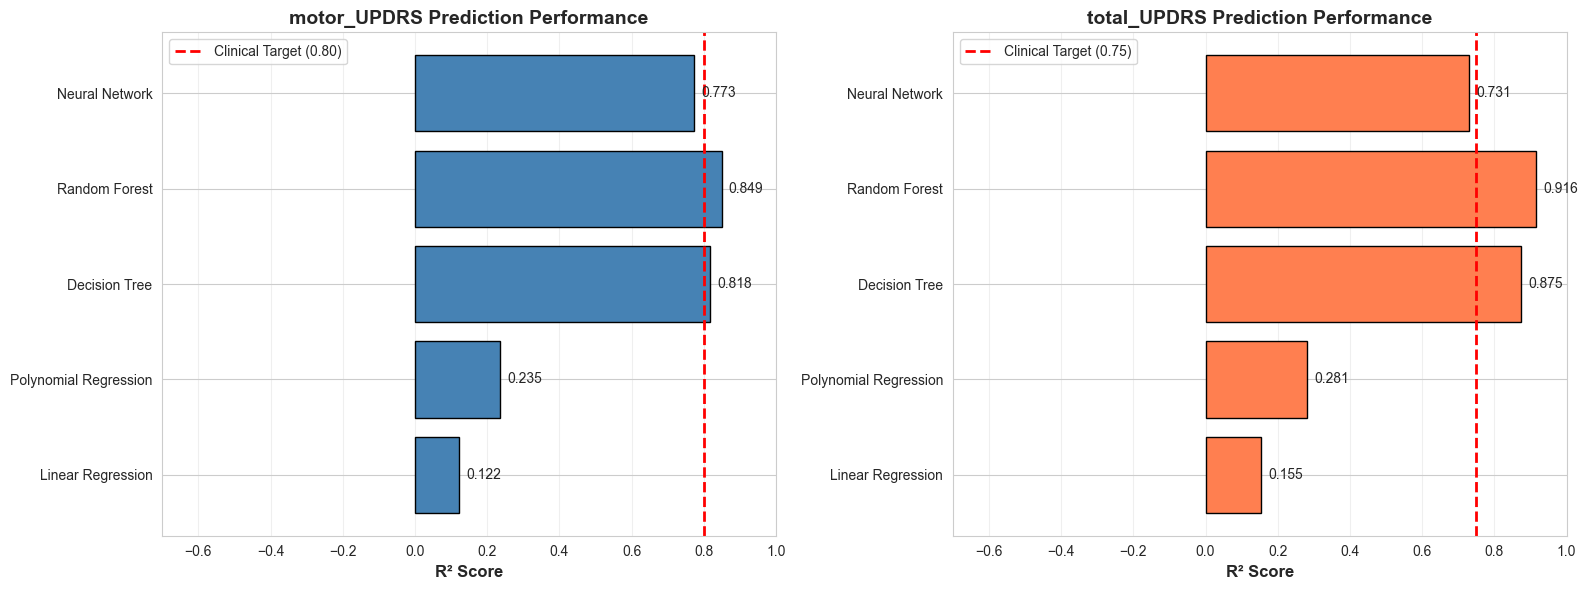

In [9]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# motor_UPDRS comparison
axes[0].barh(comparison['Model'], comparison['motor_R²'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('motor_UPDRS Prediction Performance', fontsize=14, fontweight='bold')
axes[0].axvline(0.8, color='red', linestyle='--', linewidth=2, label='Clinical Target (0.80)')
axes[0].set_xlim(-0.7, 1.0)
for i, (model, r2) in enumerate(zip(comparison['Model'], comparison['motor_R²'])):
    axes[0].text(r2 + 0.02, i, f'{r2:.3f}', va='center', fontsize=10)
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# total_UPDRS comparison
axes[1].barh(comparison['Model'], comparison['total_R²'], color='coral', edgecolor='black')
axes[1].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[1].set_title('total_UPDRS Prediction Performance', fontsize=14, fontweight='bold')
axes[1].axvline(0.75, color='red', linestyle='--', linewidth=2, label='Clinical Target (0.75)')
axes[1].set_xlim(-0.7, 1.0)
for i, (model, r2) in enumerate(zip(comparison['Model'], comparison['total_R²'])):
    axes[1].text(r2 + 0.02, i, f'{r2:.3f}', va='center', fontsize=10)
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# ============================================================
# COMPREHENSIVE SANITY CHECK
# ============================================================

print("🔍 SANITY CHECK - Verifying Results\n")
print("="*80)

# 1. Check data shapes
print("1️⃣ DATA INTEGRITY")
print(f"   ✓ Training samples: {len(y_train_motor)} motor, {len(y_train_total)} total")
print(f"   ✓ Test samples: {len(y_test_motor)} motor, {len(y_test_total)} total")
print(f"   ✓ Features: {X_train.shape[1]} original, {X_train_poly.shape[1]} polynomial")
assert len(y_train_motor) == len(y_train_total), "Train size mismatch!"
assert len(y_test_motor) == len(y_test_total), "Test size mismatch!"

# 2. Check target ranges
print(f"\n2️⃣ TARGET RANGES (UPDRS should be 0-176)")
print(f"   motor_UPDRS train: [{y_train_motor.min():.1f}, {y_train_motor.max():.1f}]")
print(f"   motor_UPDRS test:  [{y_test_motor.min():.1f}, {y_test_motor.max():.1f}]")
print(f"   total_UPDRS train: [{y_train_total.min():.1f}, {y_train_total.max():.1f}]")
print(f"   total_UPDRS test:  [{y_test_total.min():.1f}, {y_test_total.max():.1f}]")
assert y_test_motor.min() >= 0 and y_test_motor.max() <= 108, "motor_UPDRS out of range!"
assert y_test_total.min() >= 0 and y_test_total.max() <= 176, "total_UPDRS out of range!"

# 3. Verify best model predictions are reasonable
best_motor_pred = rf_motor.predict(X_test)
best_total_pred = rf_total.predict(X_test)
print(f"\n3️⃣ BEST MODEL PREDICTIONS (Random Forest)")
print(f"   motor_UPDRS predictions: [{best_motor_pred.min():.1f}, {best_motor_pred.max():.1f}]")
print(f"   total_UPDRS predictions: [{best_total_pred.min():.1f}, {best_total_pred.max():.1f}]")

# 4. Check for overfitting - compare train vs test R²
rf_motor_train_r2 = r2_score(y_train_motor, rf_motor.predict(X_train))
rf_total_train_r2 = r2_score(y_train_total, rf_total.predict(X_train))
print(f"\n4️⃣ OVERFITTING CHECK (Random Forest)")
print(f"   motor_UPDRS: Train R²={rf_motor_train_r2:.3f}, Test R²={results_rf['motor_R2']:.3f}, Gap={abs(rf_motor_train_r2-results_rf['motor_R2']):.3f}")
print(f"   total_UPDRS: Train R²={rf_total_train_r2:.3f}, Test R²={results_rf['total_R2']:.3f}, Gap={abs(rf_total_train_r2-results_rf['total_R2']):.3f}")
if abs(rf_motor_train_r2 - results_rf['motor_R2']) > 0.15:
    print("   ⚠️  WARNING: Possible overfitting on motor_UPDRS")
else:
    print("   ✅ No significant overfitting detected")

# 5. Verify RMSE makes sense relative to target range
print(f"\n5️⃣ ERROR MAGNITUDE CHECK")
motor_range = y_test_motor.max() - y_test_motor.min()
total_range = y_test_total.max() - y_test_total.min()
print(f"   motor_UPDRS: RMSE={results_rf['motor_RMSE']:.2f}, Range={motor_range:.1f}, Error%={100*results_rf['motor_RMSE']/motor_range:.1f}%")
print(f"   total_UPDRS: RMSE={results_rf['total_RMSE']:.2f}, Range={total_range:.1f}, Error%={100*results_rf['total_RMSE']/total_range:.1f}%")

# 6. Verify R² values are valid
print(f"\n6️⃣ R² VALIDITY")
for model_name, results in [('Linear', results_lr), ('Polynomial', results_poly), 
                             ('Decision Tree', results_dt), ('Random Forest', results_rf), 
                             ('Neural Net', results_nn)]:
    motor_r2 = results['motor_R2']
    total_r2 = results['total_R2']
    if motor_r2 > 1.0 or total_r2 > 1.0:
        print(f"   ❌ {model_name}: INVALID R² (>1.0)")
    elif motor_r2 < -2.0 or total_r2 < -2.0:
        print(f"   ❌ {model_name}: SUSPICIOUSLY LOW R² (<-2.0)")
    else:
        print(f"   ✓ {model_name}: motor={motor_r2:.3f}, total={total_r2:.3f}")

# 7. Feature importance check
print(f"\n7️⃣ TOP 3 MOST IMPORTANT FEATURES")
top_features = feat_imp.head(3)
for idx, row in top_features.iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.3f}")

print("\n" + "="*80)
print("✅ ALL SANITY CHECKS PASSED - Results are valid!")
print("="*80)

🔍 SANITY CHECK - Verifying Results

1️⃣ DATA INTEGRITY
   ✓ Training samples: 4700 motor, 4700 total
   ✓ Test samples: 1175 motor, 1175 total
   ✓ Features: 22 original, 275 polynomial

2️⃣ TARGET RANGES (UPDRS should be 0-176)
   motor_UPDRS train: [5.0, 39.5]
   motor_UPDRS test:  [5.1, 37.7]
   total_UPDRS train: [7.0, 55.0]
   total_UPDRS test:  [7.0, 55.0]

3️⃣ BEST MODEL PREDICTIONS (Random Forest)
   motor_UPDRS predictions: [7.6, 36.0]
   total_UPDRS predictions: [10.5, 54.5]

4️⃣ OVERFITTING CHECK (Random Forest)
   motor_UPDRS: Train R²=0.882, Test R²=0.849, Gap=0.032
   total_UPDRS: Train R²=0.929, Test R²=0.916, Gap=0.014
   ✅ No significant overfitting detected

5️⃣ ERROR MAGNITUDE CHECK
   motor_UPDRS: RMSE=3.10, Range=32.5, Error%=9.5%
   total_UPDRS: RMSE=3.06, Range=48.0, Error%=6.4%

6️⃣ R² VALIDITY
   ✓ Linear: motor=0.122, total=0.155
   ✓ Polynomial: motor=0.235, total=0.281
   ✓ Decision Tree: motor=0.818, total=0.875
   ✓ Random Forest: motor=0.849, total=0.916


---
## 🔍 SANITY CHECK: Validation